In [ ]:
# !!! only run when using colab !!!
import os
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
os.chdir("/content/CPlantBox/")
! cmake .
! make
os.chdir("/content/CPlantBox/tutorial/jupyter/workshop_11_2_2022/")

# Workshop 11.2.2022 - (2/3)

## Post-processing (how to evaluate simulation results)

Basically, there are two methods 

1. Using class *RootSystem* directly, parameter values are per root (root system is represented by a polylines).

2. Using class *SegmentAnalyser*, which will consider all segments of the root system, parameter values are per segment (root system is represented by segments).


Furthermore, post-processing can be done per time step in a simulation loop (a), or on the final result (b). 

In [8]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
import plantbox as pb
import vtk_plot as vp # for quick vizualisations
import matplotlib.pyplot as plt # for 2d plots
import numpy as np

A typical simulation loop will look like

In [9]:
rs = pb.RootSystem()
path = "../../../modelparameter/rootsystem/"
name = "Zea_mays_1_Leitner_2010"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

""" Simulation loop """
simtime = 60.  # final simulation time [day]
dt = 1. # time step [day]
N = round(simtime / dt)  # number of iterations

for i in range(0, N):
    
    # Coupling to plant functional models or soil     
    
    rs.simulate(dt)
    
    # Coupling to plant functional models or soil 
    
    # Code for post-processing per time step (e.g. store relevant information in a list)
    

# Code for post-processing of the final result (write relevant results, e.g. csv, xls, etc.)
_  = vp.plot_roots(rs, "subType") # Plot, using vtk

### 1a. Analyse results from the class *RootSystem* directly (values per root) in a loop

The following example will plot length versus time for the root system, and each subType (see *example2d_length.py*)

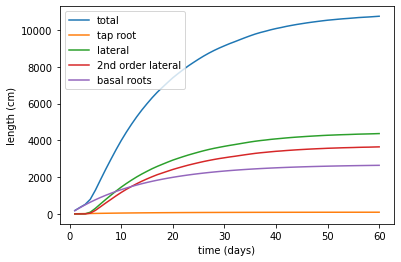

In [10]:
rs.initialize() # reset
scalar_type = "length" # "surface", "volume"
v_, v1_, v2_, v3_, v4_ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)

""" Simulation loop """
for i in range(0, N):
    rs.simulate(dt)
    t = np.array(rs.getParameter("subType")) # value per root
    v = np.array(rs.getParameter(scalar_type)) # all random or specific parameters are accessible
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t == 1])
    v2_[i] = np.sum(v[t == 2])
    v3_[i] = np.sum(v[t == 3])
    v4_[i] = np.sum(v[t == 4])
    
t_ = np.linspace(dt, N * dt, N)
plt.plot(t_, v_, t_, v1_, t_, v2_, t_, v3_, t_, v4_)
plt.xlabel("time (days)")
plt.ylabel(scalar_type + " (cm)")
plt.legend(["total", "tap root", "lateral", "2nd order lateral", "basal roots"])
# plt.savefig("myplot.png") # we could save it as png
plt.show()

### 1b. Analyse results from the class *RootSystem* directly (values per root), pure post-processing

Total length 10610.93638389835 cm


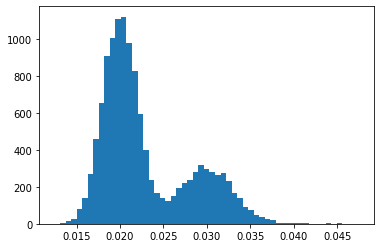

In [11]:
# Simulation
rs.initialize() # reset
rs.simulate(simtime)

# Post processing
print("Total length", np.sum(rs.getParameter("length")), "cm")

a = rs.getParameter("radius")
_ = plt.hist(a, bins='auto')

# vp.plot_roots(rs, "subType") # Plot, using vtk 

It is possible to obtain all specific parameters of roots that have been created

In [12]:
p = []
roots = rs.getRoots()
for r in roots:
    p.append(r.param()) 
print(len(roots), "roots\n")
print(p[3]) # specific parameters of root 2

12627 roots

subType	2
lb	0.211148
la	0.327437
nob	1
r	1.84893
a	0.0280957
theta	0.95268
rlt	8.47161e+08
ln	



## 2a. Analyse results from the class *SegmentAnalyser* (values per segment) in a loop

Main functionality of *SegmentAnalyser* class
* getParameter(name) as before, but with value for each segment, especially "creationTime" of each segment
* filter(name, min, max) will keep only segments where parameter name is within [min, max]
* crop(sdf) will cut the segments with a geometry (e.g. in a soil core)
* distribution(...) will create a 1d plot versus depth, where parameters are summed in layers 
* distribution2d(...) as above but 2d
* mapPeriodic(length, width) maps the unconstrained root system into a periodic domain
* addData(name, data) attach user data to the segments (for visualization or export)

Note that *SegmentAnalyser* is only loosly connected to the original simulation.

The first example shows how to obtain a depth distribution (values per segment) in a simulation loop.

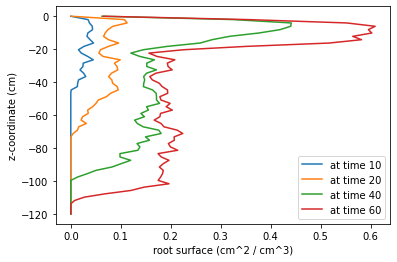

In [13]:
rs = pb.RootSystem()
path = "../../../modelparameter/rootsystem/"
name = "Moraesetal_2018"
rs.readParameters(path + name + ".xml")
rs.setGeometry(pb.SDF_PlantBox(1.e6,1.e6,1.e6)) 
rs.initialize()

simtimes = [0,10,20,40,60] # day
dt_ = np.diff(simtimes) # day
depth = 120 # cm
layers = 60 # [1]

""" Simulation loop """
rsd_ = []
for dt in dt_:    
    rs.simulate(dt)
    ana = pb.SegmentAnalyser(rs) # create a SegmentAnalyser object
    rsd = ana.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd) # store relevant data in a list

""" vizualize rld_ """
soilvolume = (depth / layers) * 10 * 10
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]

z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, label = "at time "+str(t))

plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()
_ = vp.plot_roots(rs, "subType")

To reduce noise we can use mean value and standard deviations of multiple simulation runs, see *example3a_density.py*

## 2b. Analyse results from the class *SegmentAnalyser* (values per segment), pure post-processing

Since the creation time (*creationTime*) of the segments is known, it is often sufficient to use pure post-processing when using the *SegmentAnalyser* class. The following example is based on *example3b_sdfanalysis.py* and shows the use of *mapPeriodic*, *filter()* and *crop()*.

Minimum of bounding box ( -21.1772, -24.8524, -111.429 )
Maximum of bounding box ( 25.1568, 22.4534, 0 )


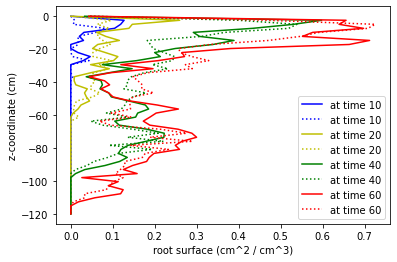

In [14]:
""" post-processing """
ana = pb.SegmentAnalyser(rs)
print("Minimum of bounding box", ana.getMinBounds())
print("Maximum of bounding box", ana.getMaxBounds())
ana.mapPeriodic(10,10)
vp.plot_roots(ana, "subType")

r, depth, layers = 2.5, 120., 50  # Soil core analysis
soilcore = pb.SDF_PlantContainer(r, r, depth, False)  # in the center of the root
soilcore2 = pb.SDF_RotateTranslate(soilcore, 0, 0, pb.Vector3d(3., 0, 0))  # shift for 3 mc

simtimes =  [0,10,20,40,60] # as before
rsd_, rsd2_ = [], []
for t in simtimes[1:]:
    a = pb.SegmentAnalyser(ana) # copy    
    a.filter("creationTime", 0, t) # keep segments with creation time in [0, time]
    a2 = pb.SegmentAnalyser(a)
    a.crop(soilcore)
    rsd = a.distribution("surface", 0., -depth, layers, True)
    rsd_.append(rsd)
    a2.crop(soilcore2)
    rsd2 = a2.distribution("surface", 0., -depth, layers, True)
    rsd2_.append(rsd2)

""" vizualize rld_ """
soilvolume = (depth / layers) * 2.5*2.5*np.pi
rsd_ = np.array(rsd_) / soilvolume  # convert to density [cm2/cm3]
rsd2_ = np.array(rsd2_) / soilvolume  # convert to density [cm2/cm3]

cols = ["b", "y", "g", "r"]
cols2 = ["b:", "y:", "g:", "r:"]
z_ = np.linspace(0, -depth, layers)  # z - axis
for i, t in enumerate(simtimes[1:]):
    plt.plot(rsd_[i,:], z_, cols[i], label = "at time "+str(t))
    plt.plot(rsd2_[i,:], z_, cols2[i], label = "at time "+str(t))
    
plt.xlabel("root surface (cm^2 / cm^3)")
plt.ylabel("z-coordinate (cm)")
plt.legend()
# plt.savefig("surface_density.png")
plt.show()

### (b.3) Exporting data using *SegmentAnalyser* (values per segment)

see *example3c_write.py*, and *example3e_animation.py* for creating an animation.

In [15]:
rs.write("as_polylines.vtp") # nicer tube plots in Paraview, but cannot map to segments

ana = pb.SegmentAnalyser(rs)
ana.write("as_segments.vtp") # coarser tube plots, but values per segment (e.g. for animation)
    
ana.mapPeriodic(10,10) # or crop, or filter, ...
ana.write("periodic_domain.vtp") 

# Geometry (we can use RootSystem class to write a Paraview macro)
periodic_domain = pb.SDF_PlantBox(10.,10.,120) # cm
soilcore = pb.SDF_PlantContainer(r, r, depth, False)  # in the center of the root
soilcore2 = pb.SDF_RotateTranslate(soilcore, 0, 0, pb.Vector3d(3., 0, 0))  # shift for 3 mc
rs.setGeometry(pb.SDF_Union([periodic_domain, soilcore, soilcore2])) 
rs.write("geometry.py")

Visualisations can be done in ParaView